In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models.forecasting.random_forest import RandomForest
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 5)]
    params = {
        'n_estimators': 150,
        'max_depth': 18,
        'min_samples_split': 13,
        'min_samples_leaf': 13,
        'max_features': 0.5774519952255706,
        'bootstrap':False,
        'criterion':"squared_error",
        'min_weight_fraction_leaf': 0.0003584570012586107,
        'n_jobs': -1
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    
    model = RandomForest(
        lags=target_lags_list,
        add_encoders=encoders,
        **params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )
    
    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    21.644367    4.652351    3.630300  0.568705   
Precipitation_accumulated       0.788832    0.888162    0.411336 -0.273817   
Humidity                      273.365894   16.533780   13.026878  0.119363   
Wind_Speed_kmh                  0.599995    0.774593    0.647799 -0.438605   
Soil_Moisture              317583.222806  563.545227  360.303287  0.478958   
Soil_Temperature               26.103499    5.109158    4.000578  0.643923   
Wind_Dir_Sin                    0.260220    0.510117    0.430408  0.178550   
Wind_Dir_Cos                    0.344459    0.586907    0.491218  0.115196   

                                SMAPE  
Temperature                 22.437127  
Precipitation_accumulated   12.191848  
Humidity                    19.860749  
Wind_Speed_kmh              58.168736  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    14.126994    3.758589    2.590783  0.593303   
Precipitation_accumulated  145750.943832  381.773419  322.795987 -2.539670   
Humidity                      507.226325   22.521686   19.350384 -3.048643   
Wind_Speed_kmh                  1.377282    1.173577    1.005632 -3.083063   
Soil_Moisture              276150.549253  525.500285  440.036859  0.820985   
Soil_Temperature               16.924112    4.113893    2.973076  0.526588   
Wind_Dir_Sin                    0.277576    0.526854    0.432179 -0.151920   
Wind_Dir_Cos                    0.577116    0.759682    0.660041  0.131927   

                                SMAPE  
Temperature                 18.403939  
Precipitation_accumulated  155.310922  
Humidity                    27.111272  
Wind_Speed_kmh             130.215854  
Soil_Mo

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE            R2  \
Temperature                    9.946855    3.153864   2.675835 -6.999513e-01   
Precipitation_accumulated      7.384269    2.717401   2.315919 -5.818101e+04   
Humidity                      17.814172    4.220684   3.507534 -4.106673e-02   
Wind_Speed_kmh                 0.003755    0.061278   0.051071          -inf   
Soil_Moisture              15560.722336  124.742624  96.210738 -1.077865e+01   
Soil_Temperature               6.133392    2.476569   2.042361  6.852444e-02   
Wind_Dir_Sin                   0.000094    0.009684   0.006830          -inf   
Wind_Dir_Cos                   0.000423    0.020567   0.017527          -inf   

                                SMAPE  
Temperature                 17.092452  
Precipitation_accumulated    0.507260  
Humidity                     4.022192  
Wind_Speed_kmh             20

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     0.891163    0.944014    0.800420 -0.515715   
Precipitation_accumulated       0.201952    0.449391    0.306802 -5.152411   
Humidity                        8.709018    2.951105    2.322417  0.088586   
Wind_Speed_kmh                  0.000033    0.005729    0.001460      -inf   
Soil_Moisture              118848.537767  344.744163  288.930473 -2.219712   
Soil_Temperature                0.082680    0.287542    0.205379  0.658875   
Wind_Dir_Sin                    0.000002    0.001469    0.000363      -inf   
Wind_Dir_Cos                    0.000008    0.002773    0.000705      -inf   

                                SMAPE  
Temperature                  8.254623  
Precipitation_accumulated    0.066974  
Humidity                     2.563529  
Wind_Speed_kmh             200.000000  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                     7.639220    2.763914    2.031320  -2.207376   
Precipitation_accumulated       1.798803    1.341194    0.606553  -5.443981   
Humidity                       55.982026    7.482114    5.825314  -0.164695   
Wind_Speed_kmh                  0.025366    0.159268    0.054064 -11.499931   
Soil_Moisture              244919.640214  494.893565  251.824076 -30.105719   
Soil_Temperature                5.608536    2.368235    1.691192  -2.450824   
Wind_Dir_Sin                    0.012118    0.110083    0.035634   0.785789   
Wind_Dir_Cos                    0.018617    0.136443    0.044301   0.784581   

                                SMAPE  
Temperature                 25.937056  
Precipitation_accumulated    0.132323  
Humidity                     6.914534  
Wind_Speed_kmh             192.263365 

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                1.183760e+01     3.440581     2.620268  -0.285777   
Precipitation_accumulated  1.633147e+01     4.041221     3.511647 -12.940479   
Humidity                   1.325492e+02    11.513003     9.301538  -0.137730   
Wind_Speed_kmh             2.330391e+00     1.526562     0.998988  -0.501529   
Soil_Moisture              3.023155e+06  1738.722112  1506.311239  -1.216506   
Soil_Temperature           1.795983e+01     4.237904     3.420957  -2.571819   
Wind_Dir_Sin               6.874814e-01     0.829145     0.550839  -0.428089   
Wind_Dir_Cos               3.356210e-01     0.579328     0.458742   0.297784   

                                SMAPE  
Temperature                 53.059768  
Precipitation_accumulated    0.763784  
Humidity                    10.334953  
Wind_Speed_kmh             12

In [5]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


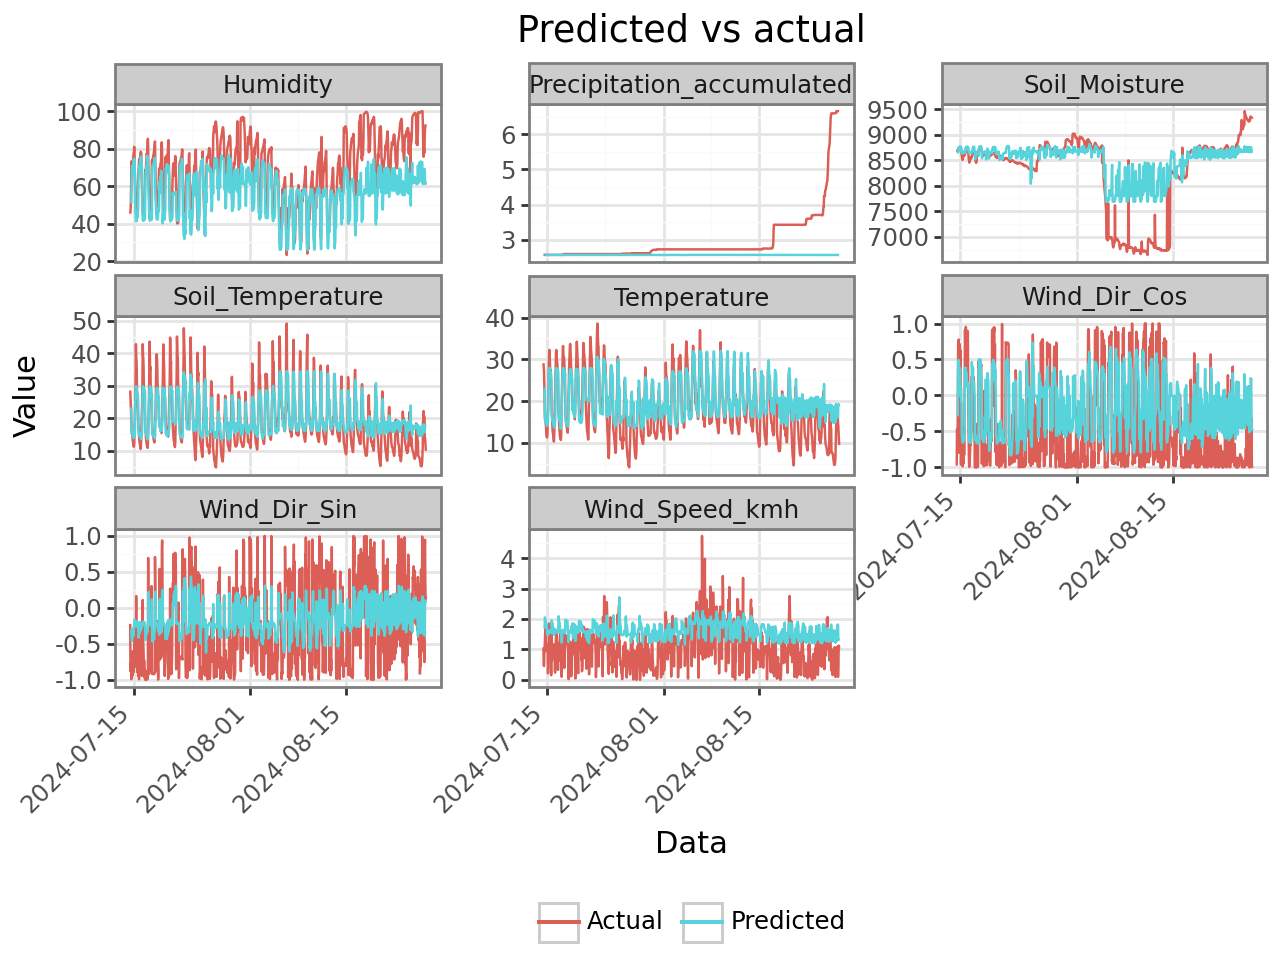

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [6]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

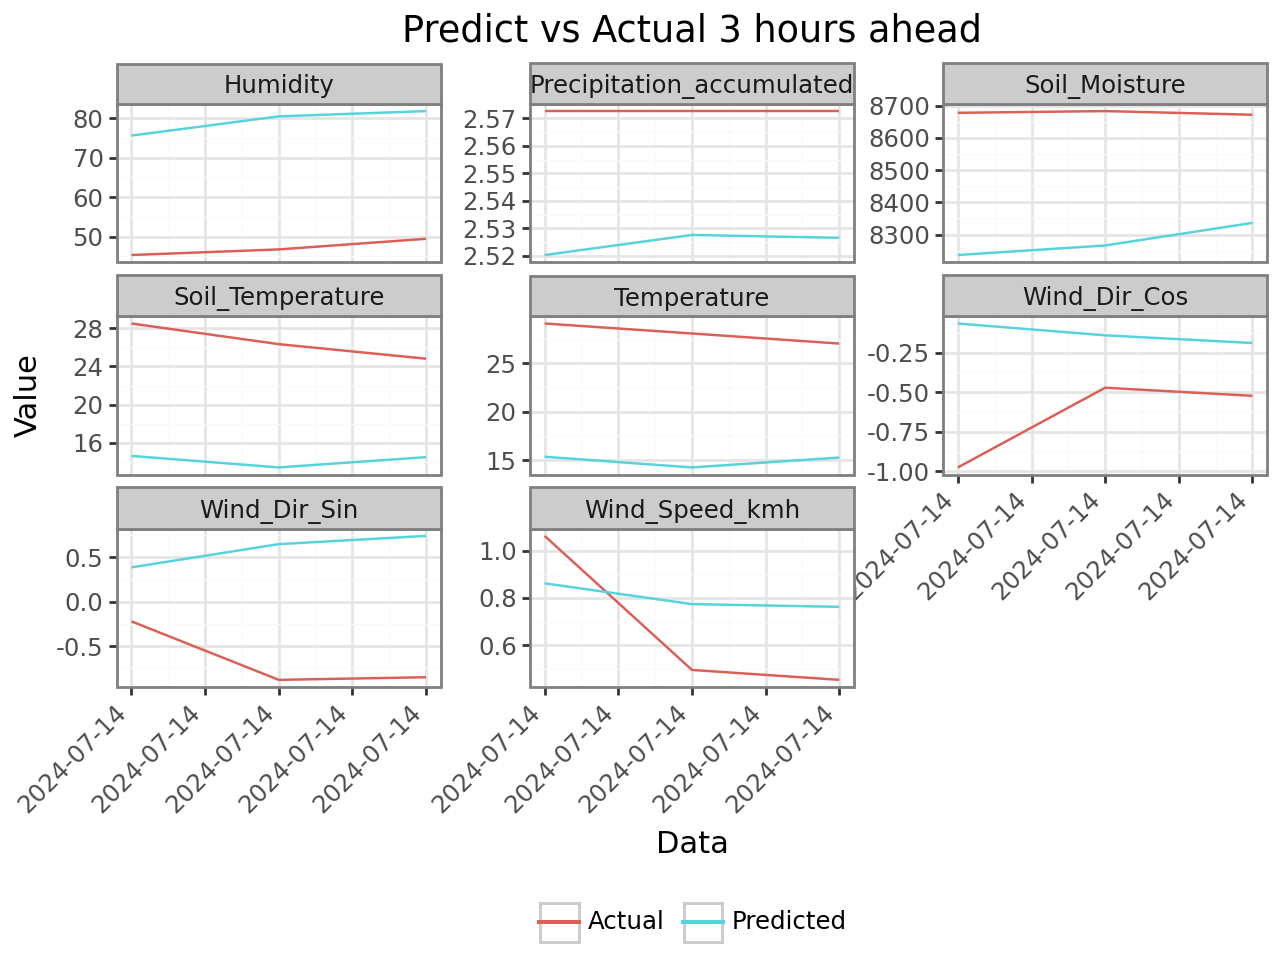

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide


{'Temperature': {'MSE': np.float64(171.69376887573767), 'RMSE': np.float64(13.103196895251848), 'MAE': np.float64(13.06865399336449), 'R2': np.float64(-240.8729547435976), 'SMAPE': np.float64(60.76057632759097)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0022914888182125077), 'RMSE': np.float64(0.04786949778525473), 'MAE': np.float64(0.047761157819992274), 'R2': np.float64(-inf), 'SMAPE': np.float64(1.8740118926450904)}, 'Humidity': {'MSE': np.float64(1035.3012464040896), 'RMSE': np.float64(32.17609743900105), 'MAE': np.float64(32.14479988435136), 'R2': np.float64(-354.18735259159195), 'SMAPE': np.float64(50.84765723406647)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.0717367916058176), 'RMSE': np.float64(0.26783724835395395), 'MAE': np.float64(0.2638890220396542), 'R2': np.float64(0.07810744680090254), 'SMAPE': np.float64(38.720175137325356)}, 'Soil_Moisture': {'MSE': np.float64(160599.16473879237), 'RMSE': np.float64(400.7482560645678), 'MAE': np.float64(398.1836960725329), 'R2':

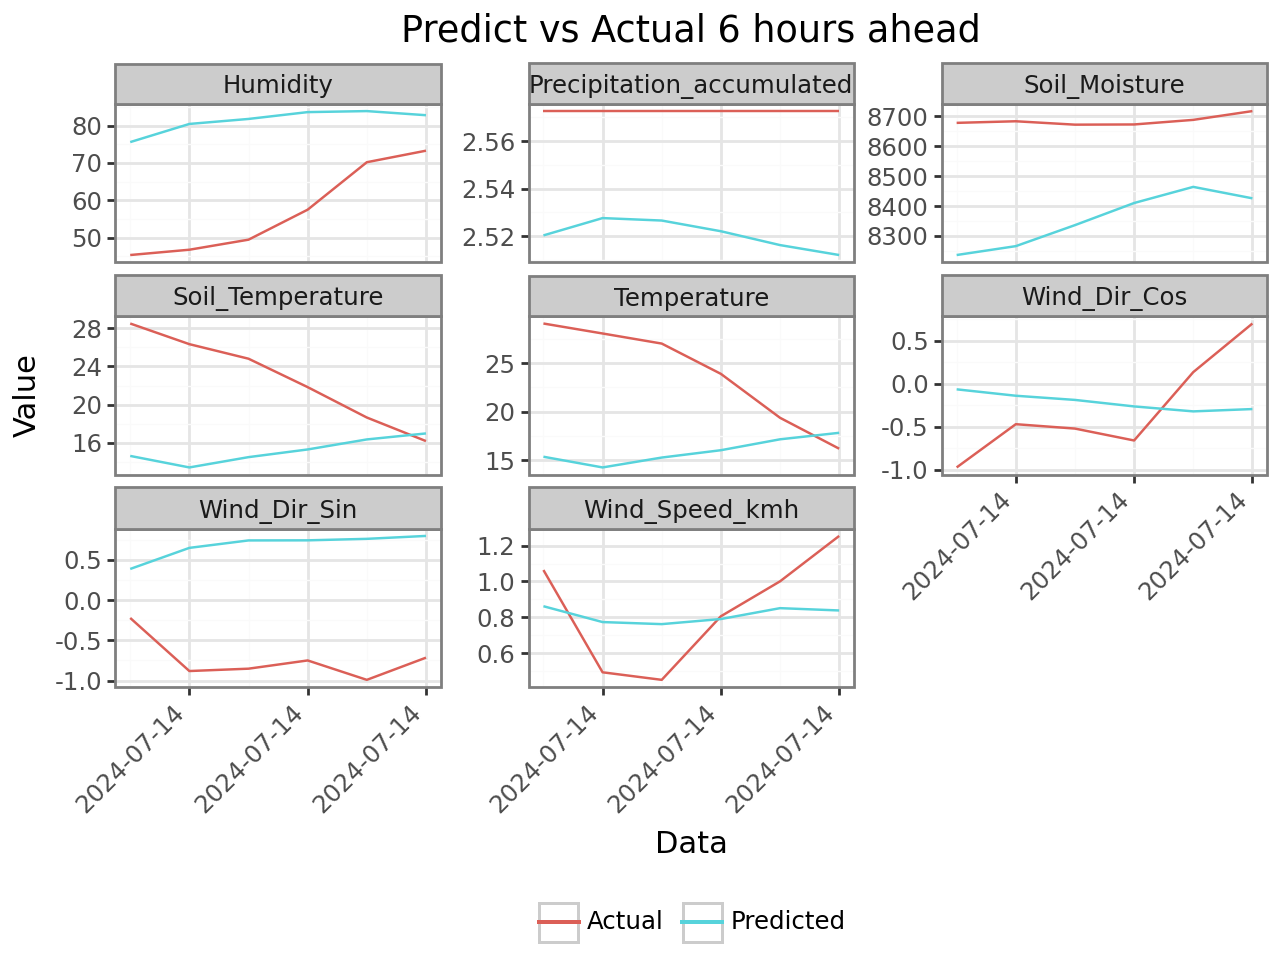

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_6.png


{'Temperature': {'MSE': np.float64(97.38719209069825), 'RMSE': np.float64(9.868494925301338), 'MAE': np.float64(8.484554698482034), 'R2': np.float64(-3.377677250124786), 'SMAPE': np.float64(40.55980319625842)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0027106739141080512), 'RMSE': np.float64(0.05206413270292756), 'MAE': np.float64(0.05177793682450268), 'R2': np.float64(-1.37447496569683e+28), 'SMAPE': np.float64(2.033365187524391)}, 'Humidity': {'MSE': np.float64(678.2992396740593), 'RMSE': np.float64(26.044178613925595), 'MAE': np.float64(24.307487770765388), 'R2': np.float64(-4.500405330082771), 'SMAPE': np.float64(36.605728471008696)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.06835984194450989), 'RMSE': np.float64(0.2614571512590732), 'MAE': np.float64(0.2286093338276367), 'R2': np.float64(0.20846394330163653), 'SMAPE': np.float64(28.984585671456728)}, 'Soil_Moisture': {'MSE': np.float64(114298.04398978269), 'RMSE': np.float64(338.0799372778318), 'MAE': np.float64(328.7359674

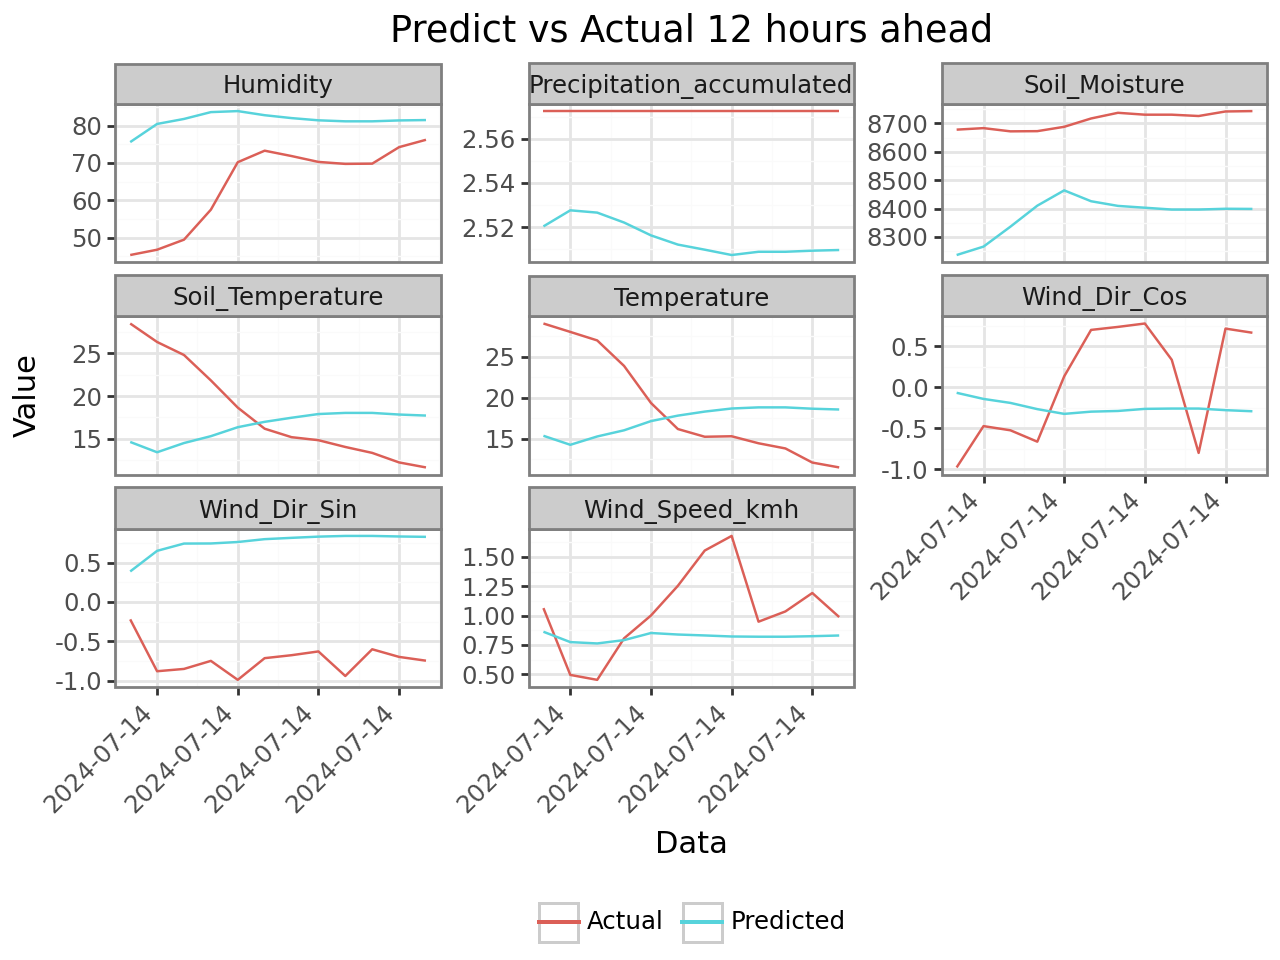

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_12.png


{'Temperature': {'MSE': np.float64(61.89742608648461), 'RMSE': np.float64(7.867491727767154), 'MAE': np.float64(6.700452681916229), 'R2': np.float64(-0.6219115527860752), 'SMAPE': np.float64(35.69954850179108)}, 'Precipitation_accumulated': {'MSE': np.float64(0.003381243255790214), 'RMSE': np.float64(0.058148458756790915), 'MAE': np.float64(0.0577133802349018), 'R2': np.float64(-1.714494017088047e+28), 'SMAPE': np.float64(2.2692347322165296)}, 'Humidity': {'MSE': np.float64(386.4111908574287), 'RMSE': np.float64(19.657344450800792), 'MAE': np.float64(16.86921271124939), 'R2': np.float64(-2.2046935424776732), 'SMAPE': np.float64(24.473454919600172)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.15771288640559522), 'RMSE': np.float64(0.3971308177485037), 'MAE': np.float64(0.3185126702069206), 'R2': np.float64(-0.3017653855423039), 'SMAPE': np.float64(32.89393748033594)}, 'Soil_Moisture': {'MSE': np.float64(113080.0858424378), 'RMSE': np.float64(336.2738256873969), 'MAE': np.float64(331.5615837

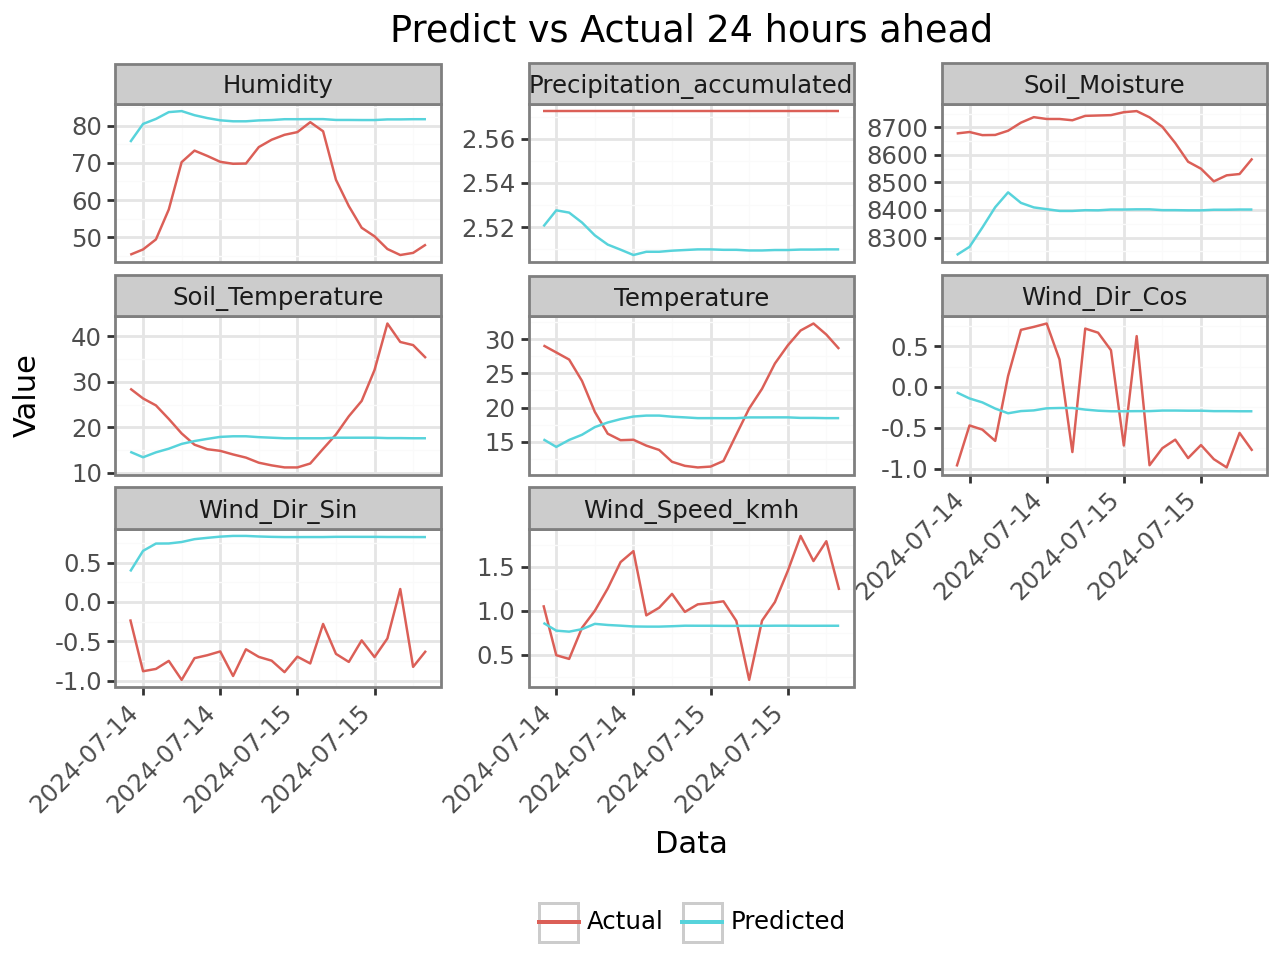

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide


{'Temperature': {'MSE': np.float64(70.09723297885772), 'RMSE': np.float64(8.372409030790225), 'MAE': np.float64(7.329859890082333), 'R2': np.float64(-0.31238496895482615), 'SMAPE': np.float64(36.78163843897029)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0036668704502870082), 'RMSE': np.float64(0.06055468974643507), 'MAE': np.float64(0.06029101558252816), 'R2': np.float64(-inf), 'SMAPE': np.float64(2.371624122585079)}, 'Humidity': {'MSE': np.float64(510.8008985463762), 'RMSE': np.float64(22.600904816984123), 'MAE': np.float64(18.94124596667805), 'R2': np.float64(-2.164530700987664), 'SMAPE': np.float64(28.082407497410866)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.2343378238560019), 'RMSE': np.float64(0.48408452139683406), 'MAE': np.float64(0.3898417212845529), 'R2': np.float64(-0.4887964008008281), 'SMAPE': np.float64(39.196961899450486)}, 'Soil_Moisture': {'MSE': np.float64(88379.49470286358), 'RMSE': np.float64(297.286889557652), 'MAE': np.float64(282.640550531356), 'R2': np.f

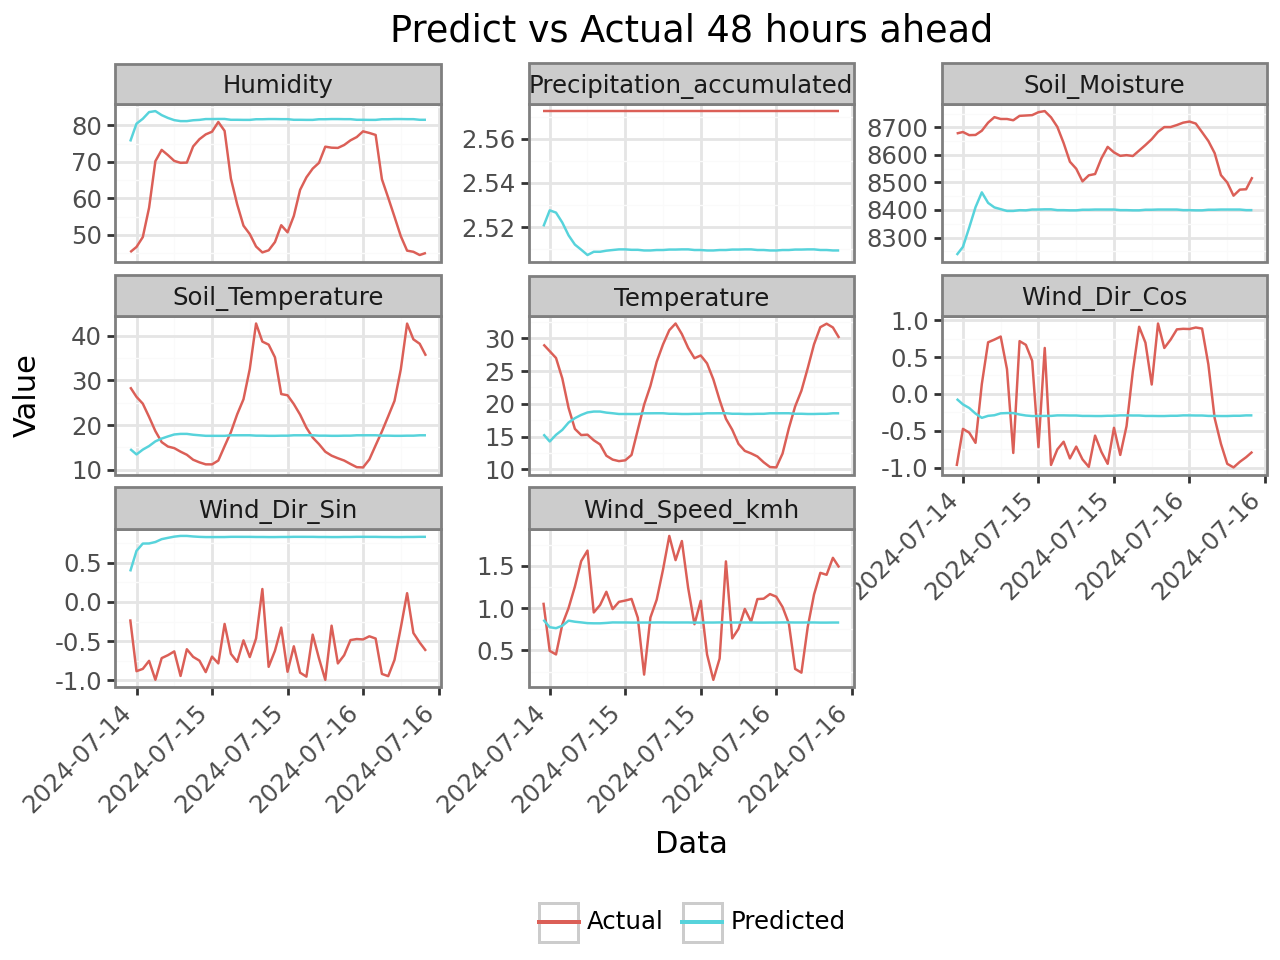

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_48.png


{'Temperature': {'MSE': np.float64(65.32572351488238), 'RMSE': np.float64(8.082433019511042), 'MAE': np.float64(7.0875580222661965), 'R2': np.float64(-0.18772753917174168), 'SMAPE': np.float64(35.73147226291175)}, 'Precipitation_accumulated': {'MSE': np.float64(0.003814623042662763), 'RMSE': np.float64(0.06176263468038554), 'MAE': np.float64(0.06161909100696777), 'R2': np.float64(-1.9342436758703546e+28), 'SMAPE': np.float64(2.424382824998009)}, 'Humidity': {'MSE': np.float64(495.98450124929633), 'RMSE': np.float64(22.270709491376703), 'MAE': np.float64(18.653391164584914), 'R2': np.float64(-2.251012170449131), 'SMAPE': np.float64(27.51089293031747)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.20613139202309072), 'RMSE': np.float64(0.45401695125082137), 'MAE': np.float64(0.3698966749187813), 'R2': np.float64(-0.20831061289449937), 'SMAPE': np.float64(40.972824650624666)}, 'Soil_Moisture': {'MSE': np.float64(70790.54186014264), 'RMSE': np.float64(266.064920386252), 'MAE': np.float64(248.879

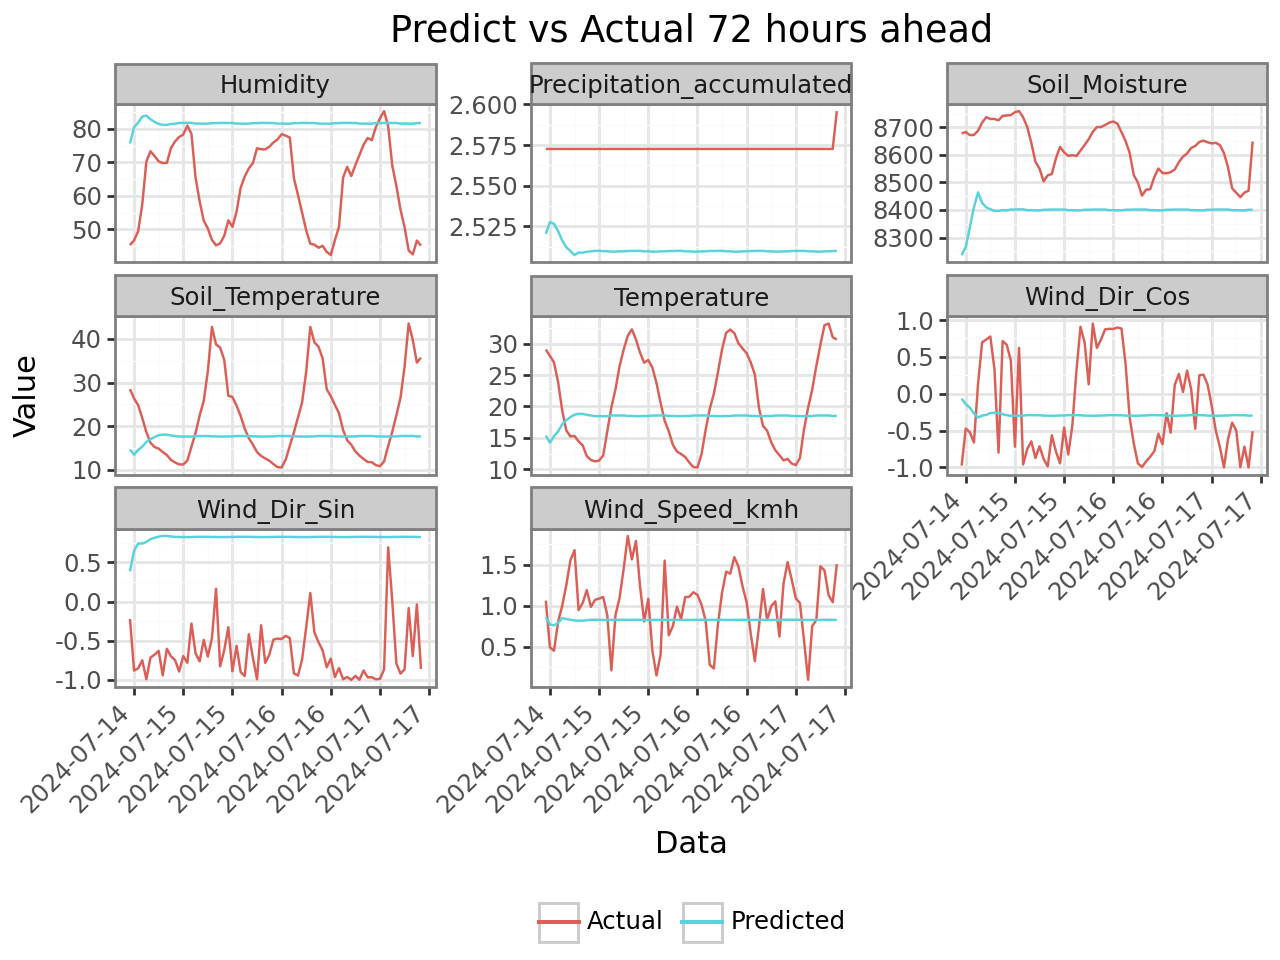

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_72.png


{'Temperature': {'MSE': np.float64(66.09218254252784), 'RMSE': np.float64(8.129709868287296), 'MAE': np.float64(7.13332301464162), 'R2': np.float64(-0.15153011552918838), 'SMAPE': np.float64(35.7741704209121)}, 'Precipitation_accumulated': {'MSE': np.float64(0.003910605696792392), 'RMSE': np.float64(0.06253483586603864), 'MAE': np.float64(0.062374061067993335), 'R2': np.float64(-525.6964137537465), 'SMAPE': np.float64(2.4540377140935425)}, 'Humidity': {'MSE': np.float64(522.9657602107814), 'RMSE': np.float64(22.868444639082504), 'MAE': np.float64(18.955710512895507), 'R2': np.float64(-2.0380398157799173), 'SMAPE': np.float64(28.148593156621374)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.19005194860988708), 'RMSE': np.float64(0.4359494794238056), 'MAE': np.float64(0.3571674032554498), 'R2': np.float64(-0.2047403037307407), 'SMAPE': np.float64(39.96908341406709)}, 'Soil_Moisture': {'MSE': np.float64(58560.980888581056), 'RMSE': np.float64(241.99376208609397), 'MAE': np.float64(223.19450002

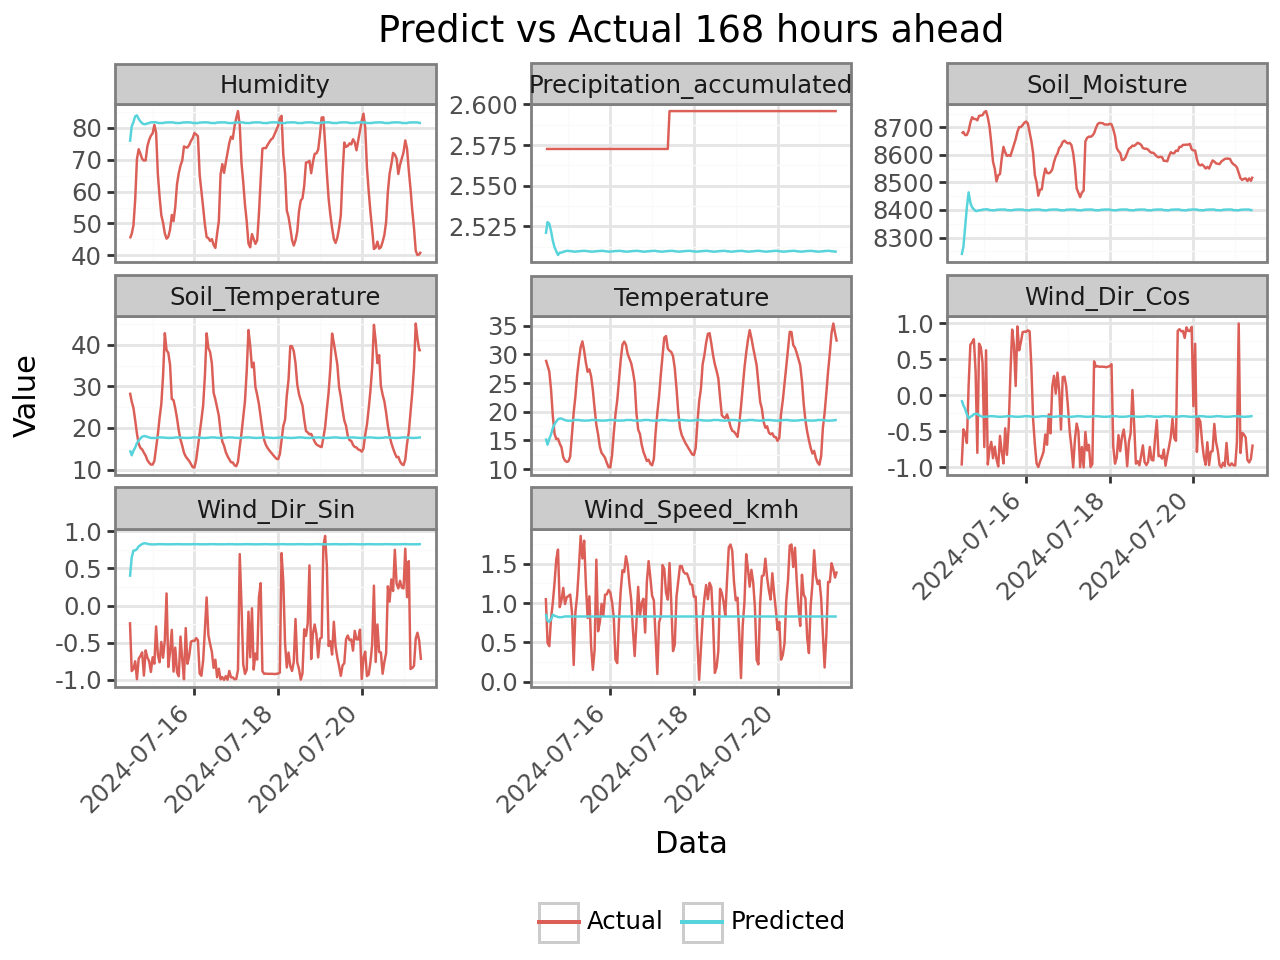

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_168.png


{'Temperature': {'MSE': np.float64(66.61306482733566), 'RMSE': np.float64(8.161682720330145), 'MAE': np.float64(6.828579698584877), 'R2': np.float64(-0.218609244719294), 'SMAPE': np.float64(32.498142540594536)}, 'Precipitation_accumulated': {'MSE': np.float64(0.005922553432062343), 'RMSE': np.float64(0.07695812778428503), 'MAE': np.float64(0.0759923432770801), 'R2': np.float64(-43.772068189312016), 'SMAPE': np.float64(2.981418789357048)}, 'Humidity': {'MSE': np.float64(525.7599954575261), 'RMSE': np.float64(22.929456937693185), 'MAE': np.float64(18.859949008991947), 'R2': np.float64(-1.9507102029787236), 'SMAPE': np.float64(28.052483894307887)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.21409283646736738), 'RMSE': np.float64(0.46270167113094307), 'MAE': np.float64(0.397057432916814), 'R2': np.float64(-0.23306928865245058), 'SMAPE': np.float64(44.791817259782185)}, 'Soil_Moisture': {'MSE': np.float64(51349.462421343786), 'RMSE': np.float64(226.6041977134223), 'MAE': np.float64(214.30071510

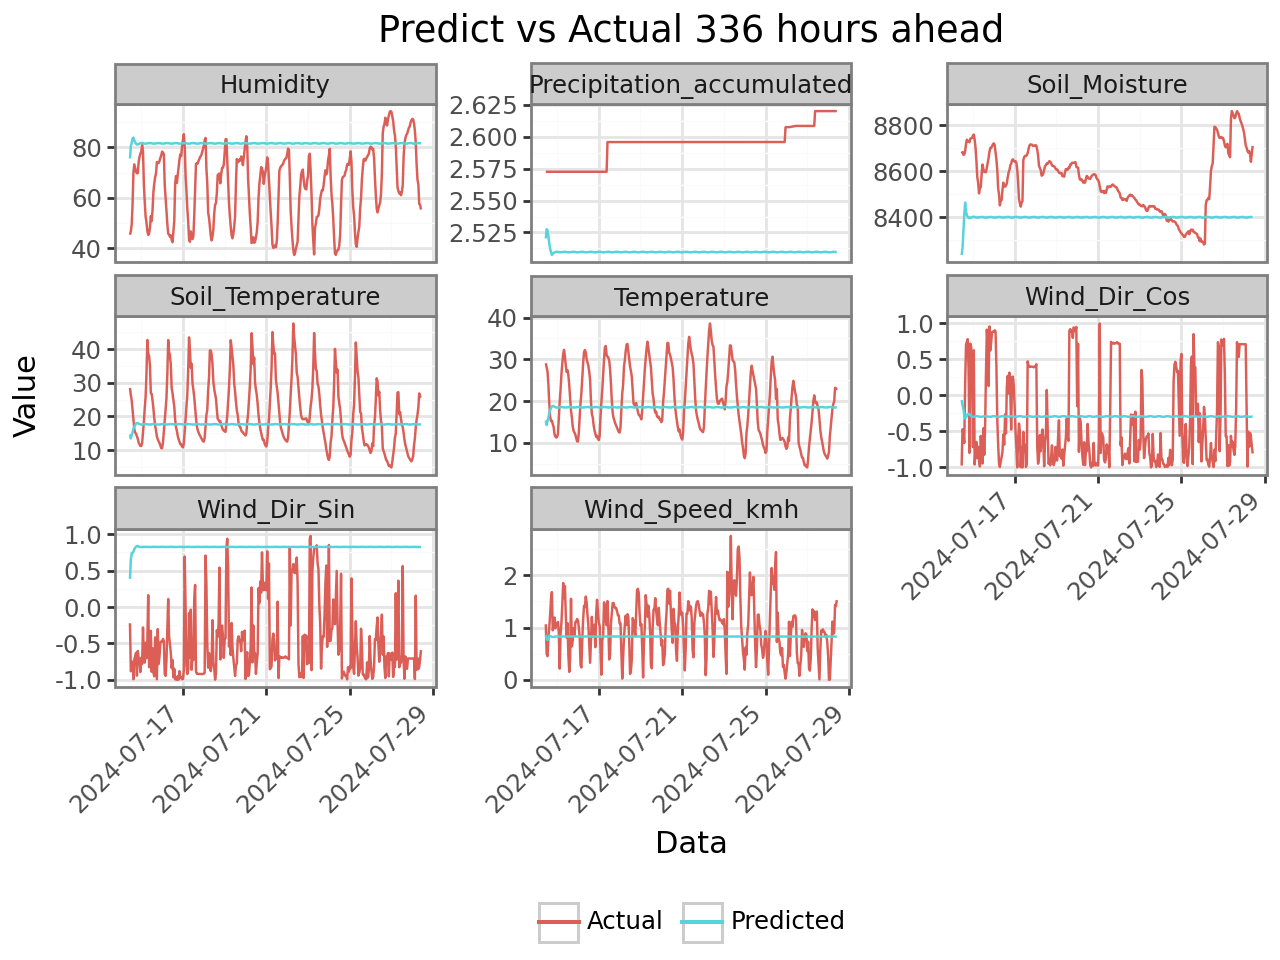

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_336.png


{'Temperature': {'MSE': np.float64(66.59269054725075), 'RMSE': np.float64(8.160434458241225), 'MAE': np.float64(6.826586959141599), 'R2': np.float64(-0.03877843748322363), 'SMAPE': np.float64(36.390816873286)}, 'Precipitation_accumulated': {'MSE': np.float64(0.007278131324625408), 'RMSE': np.float64(0.08531196472140005), 'MAE': np.float64(0.08423108018308502), 'R2': np.float64(-41.18098094588996), 'SMAPE': np.float64(3.299337731658316)}, 'Humidity': {'MSE': np.float64(490.8193425888874), 'RMSE': np.float64(22.154442953703157), 'MAE': np.float64(18.09488901467994), 'R2': np.float64(-1.3359985258879146), 'SMAPE': np.float64(26.701830000246733)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.29168601717249926), 'RMSE': np.float64(0.5400796396574299), 'MAE': np.float64(0.44114883094835006), 'R2': np.float64(-0.1534066367944804), 'SMAPE': np.float64(49.572929351400845)}, 'Soil_Moisture': {'MSE': np.float64(46248.07754633395), 'RMSE': np.float64(215.05366201563263), 'MAE': np.float64(181.8725301361

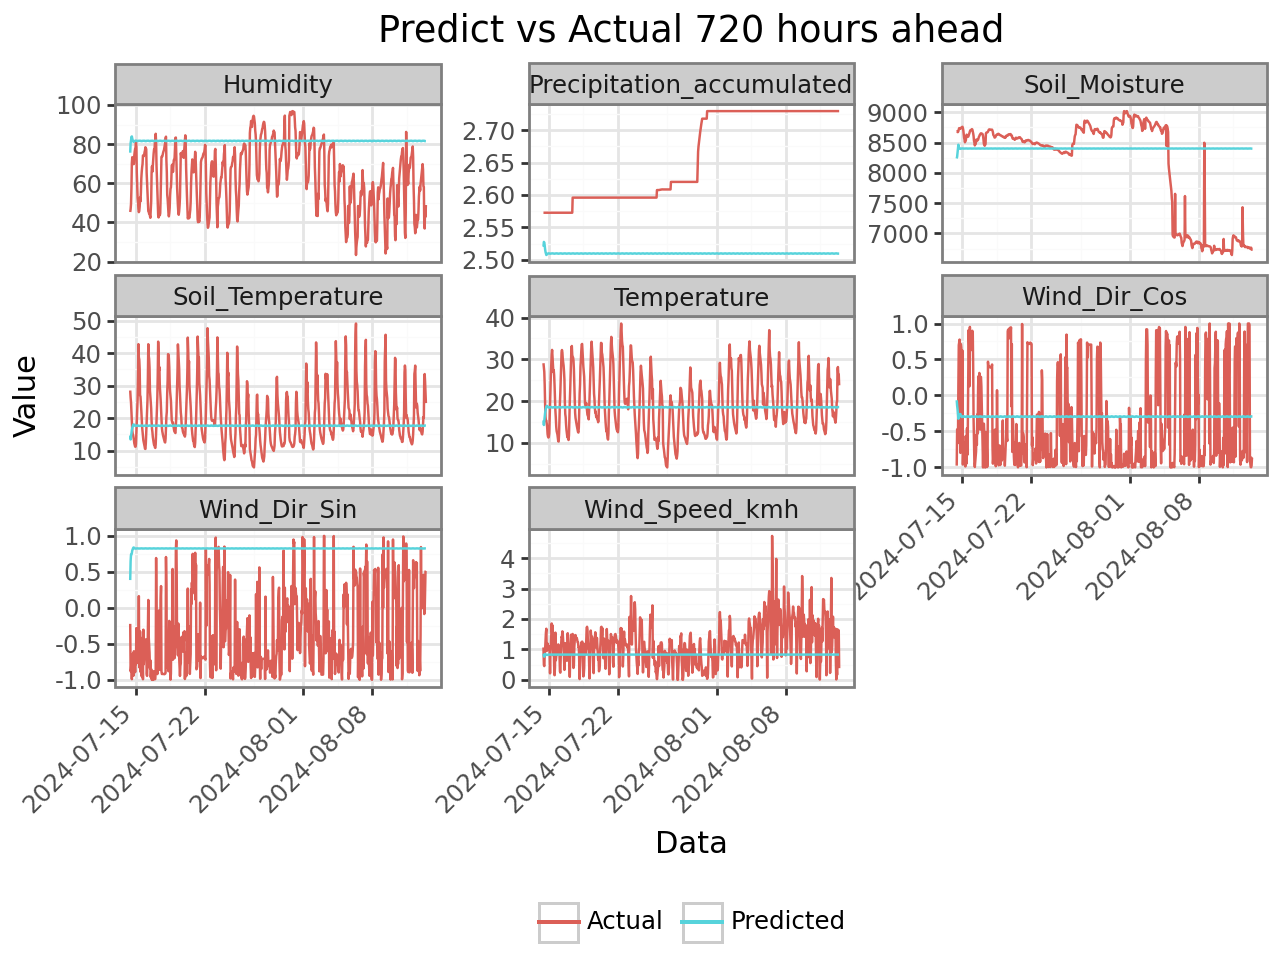

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_720.png


{'Temperature': {'MSE': np.float64(52.536557011710165), 'RMSE': np.float64(7.248210607571372), 'MAE': np.float64(5.976997921928287), 'R2': np.float64(-0.04160637335700135), 'SMAPE': np.float64(31.177947824304052)}, 'Precipitation_accumulated': {'MSE': np.float64(0.02686169631238229), 'RMSE': np.float64(0.16389538221799385), 'MAE': np.float64(0.14974922585686978), 'R2': np.float64(-5.076859377391577), 'SMAPE': np.float64(5.7617091079237275)}, 'Humidity': {'MSE': np.float64(607.5580634205439), 'RMSE': np.float64(24.64869293533724), 'MAE': np.float64(20.063484446107537), 'R2': np.float64(-1.2681330941199995), 'SMAPE': np.float64(30.364109123904246)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.573778204343297), 'RMSE': np.float64(0.7574814877891716), 'MAE': np.float64(0.5885787897928495), 'R2': np.float64(-0.28753025422122214), 'SMAPE': np.float64(57.23344738277965)}, 'Soil_Moisture': {'MSE': np.float64(734213.5649119929), 'RMSE': np.float64(856.8626289621884), 'MAE': np.float64(612.1607679573

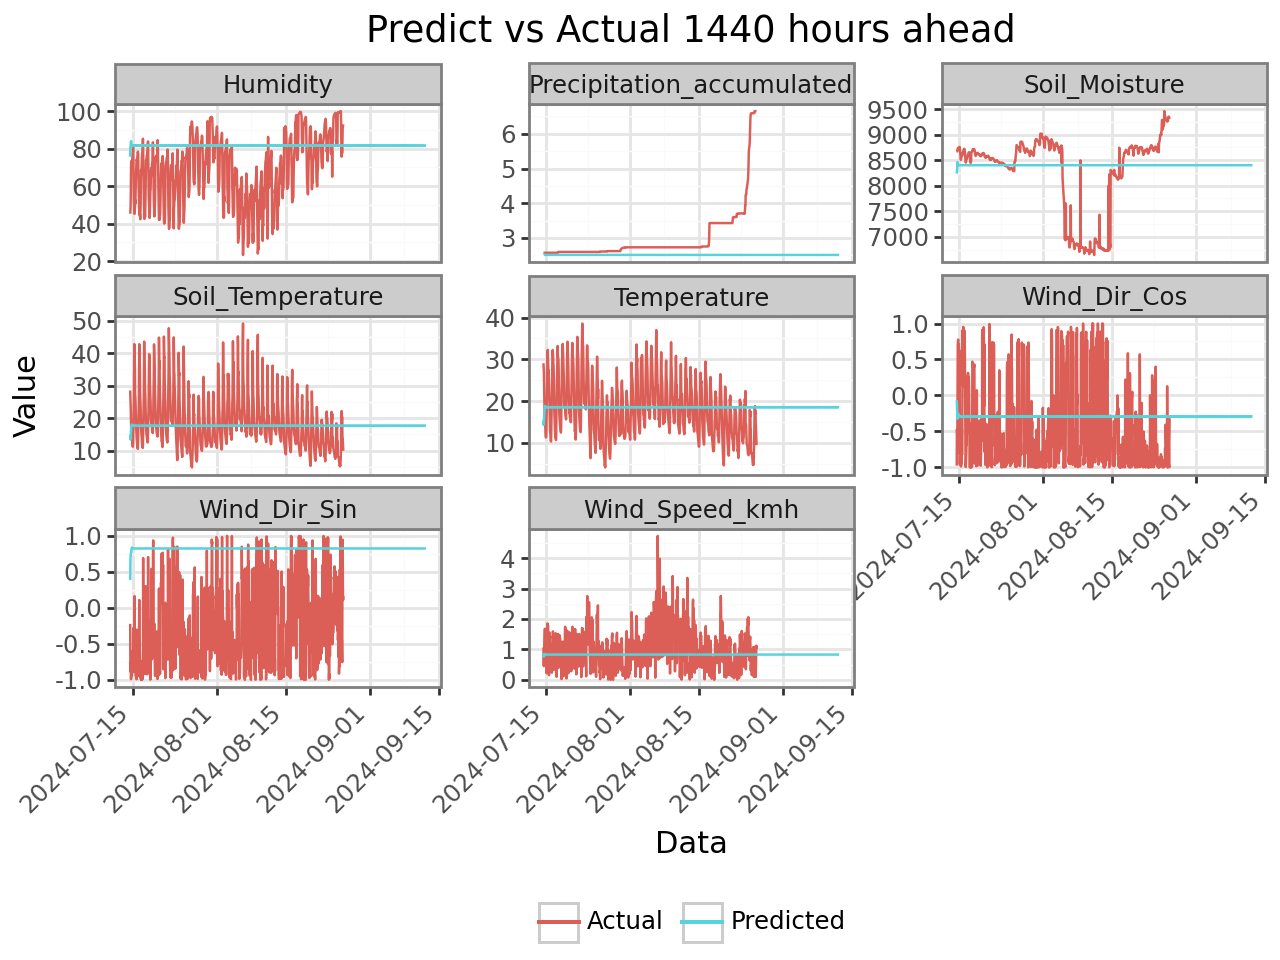

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/RandomForest/predict_1440.png


{'Temperature': {'MSE': np.float64(50.62667509201847), 'RMSE': np.float64(7.115242447873331), 'MAE': np.float64(5.914851615444322), 'R2': np.float64(-0.006495990211623948), 'SMAPE': np.float64(33.44867445470367)}, 'Precipitation_accumulated': {'MSE': np.float64(0.8396244720190694), 'RMSE': np.float64(0.916310248779893), 'MAE': np.float64(0.47121892256471654), 'R2': np.float64(-0.359660047962018), 'SMAPE': np.float64(14.532754766516106)}, 'Humidity': {'MSE': np.float64(474.5099520228162), 'RMSE': np.float64(21.783249344916754), 'MAE': np.float64(17.246427090545343), 'R2': np.float64(-0.527139881092902), 'SMAPE': np.float64(25.26292739971296)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.48694532855173434), 'RMSE': np.float64(0.6978146806650992), 'MAE': np.float64(0.5390465684957223), 'R2': np.float64(-0.1697257632564375), 'SMAPE': np.float64(56.573316435919544)}, 'Soil_Moisture': {'MSE': np.float64(626088.0019892324), 'RMSE': np.float64(791.2572287121504), 'MAE': np.float64(568.5307550217677

In [7]:
m = "RandomForest"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [8]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)